# FEA Bending Modes

In [38]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from M1S_tools import *

plt.jet()

%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [42]:
dataFolder = '/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents'

TRDate = '20Dec2024'
TRDate = '05Jan2025'

TRIFFolder = '/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_normalised_%s/'%TRDate
#read Afz (Fz influence matrix) - 01/02/2025. Trupti confirmed on slack that this is surface normal
df = pd.read_csv(dataFolder+TRIFFolder+'Afz-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
Afz = np.array(df)
print('Afz = ',Afz.shape)
# this is Afz only; it is 28789 x 176. last 6 being HPs

#read Afx (Fx influence matrix)
df = pd.read_csv(dataFolder+TRIFFolder+'Afz-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
Afx = np.array(df)
print('Afx = ', Afx.shape)

#read Afy (Fy influence matrix)
df = pd.read_csv(dataFolder+TRIFFolder+'Afz-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
Afy = np.array(df)
print('Afy = ', Afy.shape)

Afz =  (28789, 170)
Afx =  (28789, 170)
Afy =  (28789, 170)


In [43]:
#read Fz Bending Modes & forces (note: Uzm is for the moments.)
df = pd.read_csv(dataFolder+TRIFFolder+'Uz_norm-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
UMat = np.array(df)
print('U matrix', UMat.shape)

df = pd.read_csv(dataFolder+TRIFFolder+'Sz_norm-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
SMat = np.array(df)
print('S matrix', SMat.shape)

df = pd.read_csv(dataFolder+TRIFFolder+'Vz_norm-nohp-%s-%s-%s.csv'%(TRDate[:2],TRDate[2:5],TRDate[5:]), header=None)
VMat = np.array(df)
print('V matrix', VMat.shape)

U matrix (28789, 170)
S matrix (170, 170)
V matrix (170, 170)


In [44]:
#read FEA nodes data
df = pd.read_csv(dataFolder+TRIFFolder+'surfacenodes_M1B-20-Dec-2024.csv')
nodeID = np.array(df['nodeID'])
nodex = np.array(df['X'])
nodey = np.array(df['Y'])
nodez = np.array(df['Z'])
print('N node = ', len(nodeID), len(nodex))

N node =  28789 28789


In [45]:
# use these indices to remove surface nodes outside of CA
noder = np.sqrt(nodex**2+nodey**2)
insideCA = noder< np.max(nodex_ml) #diameter_of_CA/2.0
nodeID = nodeID[insideCA]
nodex = nodex[insideCA]
nodey = nodey[insideCA]
nodez = nodez[insideCA]
Afz = Afz[insideCA, :]

### check Trupti's matrices

In [10]:
#is TR still doing SVD with HPs included??????????????
print(UMat.shape, VMat.shape, SMat.shape)

(28789, 176) (176, 176) (176, 176)


In [48]:
#did she exclude nodes beyond 4.18m?
print(UMat.shape, SMat.shape, VMat.shape, Afz.shape)

(28789, 170) (170, 170) (170, 170) (27547, 170)


In [46]:
print(Afz[:3,:3])

#reconstruct Afz using U,S,V from Trupti
aa = UMat@SMat@VMat.transpose()/176
print(aa[:3,:3])

[[2.05022365e-09 1.37232774e-09 7.13583949e-10]
 [2.01904394e-09 1.35469314e-09 7.01017322e-10]
 [1.97760889e-09 1.33069226e-09 6.83850134e-10]]
[[1.98032966e-09 1.32554384e-09 6.89257224e-10]
 [1.95021289e-09 1.30851042e-09 6.77119004e-10]
 [1.91019040e-09 1.28532775e-09 6.60537061e-10]]


In [49]:
#check BM normalization
print("manually calculated RMS; numpy STD; numpy mean")
for i in np.arange(1,165,10):
    print('%.2f, %.2f, %+.2f'%(np.sqrt(np.sum(UMat[:,i]**2)/UMat.shape[0] ), 
          np.std(UMat[:,i]), np.mean(UMat_ml[:,i])))

manually calculated RMS; numpy STD; numpy mean
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, +0.00
1.00, 1.00, -0.00
1.00, 1.00, +0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00
1.00, 1.00, +0.00
1.00, 1.00, -0.00
1.00, 1.00, +0.00
1.00, 1.00, -0.00
1.00, 1.00, -0.00


In [28]:
df = pd.read_csv(dataFolder+TRIFFolder+'Vz_norm-20-Dec-2024.csv', header=None)
VMat = np.array(df)
VMat = np.linalg.pinv(SMat@VMat.T/176)*1e-6
#1e-6 due to meter to micron conversion

In [50]:
#check BM force normalization
print("modeID; manually calculated RMS; RSS; numpy STD; numpy mean")
for i in np.arange(0,16):
    print('%3d, %8.1f, %8.1f, %8.1f, %+.2f'%(i+1, np.sqrt(np.sum(VMat[:,i]**2)/VMat.shape[0] ), 
                                         np.sqrt(np.sum(VMat[:,i]**2) ), 
          np.std(VMat[:,i]), np.mean(VMat[:,i])))

modeID; manually calculated RMS; RSS; numpy STD; numpy mean
  1,      1.0,     13.0,      1.0, +0.00
  2,      1.0,     13.0,      1.0, +0.00
  3,      1.0,     13.0,      1.0, +0.00
  4,      1.0,     13.0,      1.0, +0.00
  5,      1.0,     13.0,      1.0, -0.00
  6,      1.0,     13.0,      1.0, +0.00
  7,      1.0,     13.0,      1.0, -0.00
  8,      1.0,     13.0,      1.0, -0.00
  9,      1.0,     13.0,      1.0, +0.00
 10,      1.0,     13.0,      1.0, +0.00
 11,      1.0,     13.0,      1.0, -0.00
 12,      1.0,     13.0,      1.0, -0.00
 13,      1.0,     13.0,      1.0, -0.00
 14,      1.0,     13.0,      1.0, +0.00
 15,      1.0,     13.0,      1.0, -0.00
 16,      1.0,     13.0,      1.0, +0.00


Looking at original data from Trupti

Text(0.05, 0.5, 'Force to Surface conversion \n via RFCML influence matrix')

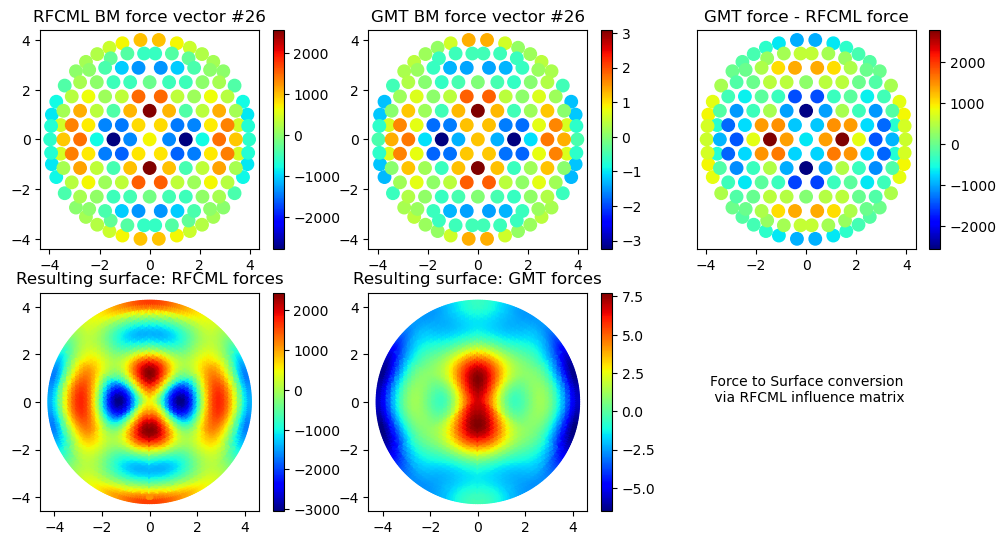

In [51]:
fig, ax = plt.subplots(2,3, figsize=(12,6.25))

modeID = 26
f1 = VMat_ml[:,modeID-1] #ML force for this bm
f2 = -gmtFvec2mlFvec(VMat[:,modeID-1]) #GMT force for this bm, converted onto ML force vector format
img = ax[0][0].scatter(sax_ml, say_ml,80, f1)
fig.colorbar(img, ax=ax[0][0])
ax[0][0].set_title("RFCML BM force vector #%d"%modeID)

img = ax[0][1].scatter(sax_ml, say_ml,80, f2)
fig.colorbar(img, ax=ax[0][1])
ax[0][1].set_title('GMT BM force vector #%d'%modeID)

idx = np.abs(f1-f2)>0
img = ax[0][2].scatter(sax_ml[~idx], say_ml[~idx],80, marker='o', facecolors='none', edgecolors='k')
img = ax[0][2].scatter(sax_ml[idx], say_ml[idx],80, f2[idx]-f1[idx])
fig.colorbar(img, ax=ax[0][2])
ax[0][2].set_yticks([])
#ax[0][2].set_title('Where force diff > 200N')
ax[0][2].set_title('GMT force - RFCML force')

img = ax[1][0].scatter(nodex_ml, nodey_ml, 10, Afn_ml @ f1)
fig.colorbar(img, ax=ax[1][0])
ax[1][0].set_title('Resulting surface: RFCML forces')
ax[1][1].set_title('Resulting surface: GMT forces')

img = ax[1][1].scatter(nodex_ml, nodey_ml, 10, Afn_ml @ f2)
fig.colorbar(img, ax=ax[1][1])
ax[1][2].axis('off')
ax[1][2].text(.05, .5, 'Force to Surface conversion \n via RFCML influence matrix')

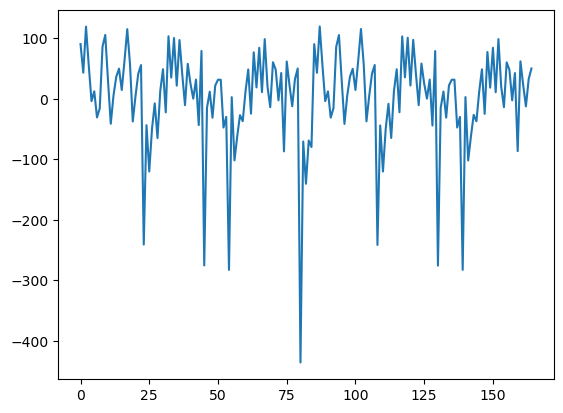

In [79]:
plt.plot(f1-f2)